# Analysis and Visualization code for mouse brain data
## 20241219

In [9]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats
import warnings
import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
# set the working directory
os.chdir("Spatial_DC_V1")
dataset_dir = "datasets/mouse_brain_coronal/"
scaler = MinMaxScaler(feature_range=(0, 1))

# Visualization of original reference data and spatial proteomics data.

         Falling back to preprocessing with `sc.pp.pca` and default params.


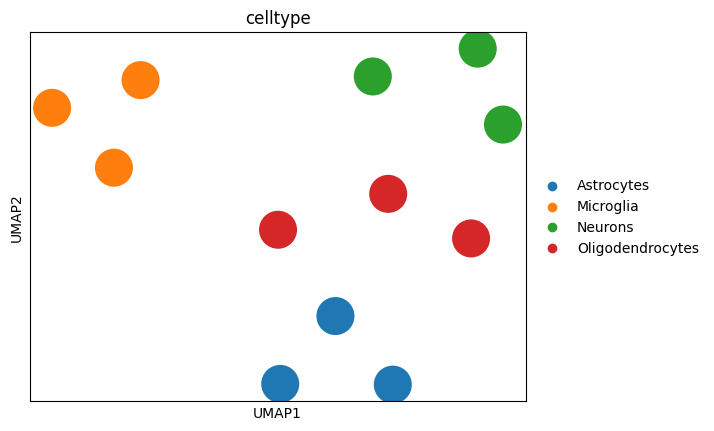

In [5]:
# Visualization of reference data
sc_adata = sc.read_h5ad(f"{dataset_dir}/original_reference_proteomics.h5ad")

# vis with UMAP
sc.pp.normalize_total(sc_adata)
sc.pp.log1p(sc_adata)

sc.pp.neighbors(sc_adata, n_pcs=10, n_neighbors=5)
sc.tl.umap(sc_adata)

sc.pl.umap(sc_adata, color=["celltype"], size=3000)


#  Quantitative assessment of Spatial-DC’s deconvolution performance on mouse brain coronal data

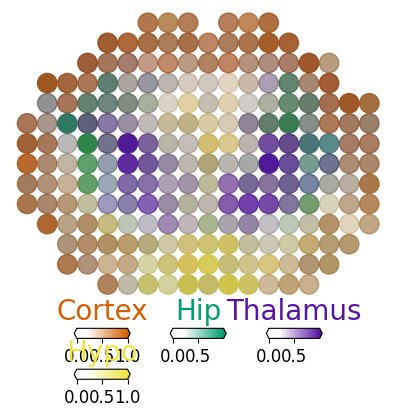

In [7]:
# visualization of regional markers from original spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")

sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

pids = ["Q9JJV5", "P97441","Q8CC35"] #Cortex
sp_adata.obs["Cortex"]= np.mean(sp_adata.to_df()[pids],axis=1)
   
pids = ["P51830", "Q8VHW2","Q0VE82","P23818","Q61097","P62748","Q9QVP9","Q3UH99"] #Hip
sp_adata.obs["Hip"]= np.mean(sp_adata.to_df()[pids],axis=1)            

pids = ["Q3TVA9", "P28867","Q91YE8"] #Tha 
sp_adata.obs["Thalamus"]= np.mean(sp_adata.to_df()[pids],axis=1)            

pids = ["P12961", "Q99P58","Q9QXV0"] #Hypo
sp_adata.obs["Hypo"]= np.mean(sp_adata.to_df()[pids],axis=1)            

sp_adata.obs[["Cortex", "Hip", "Thalamus", "Hypo"]]= scaler.fit_transform(sp_adata.obs[["Cortex", "Hip", "Thalamus", "Hypo"]])
# show the co-localization of interacted cells
plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["Cortex", "Hip", "Thalamus", "Hypo"],
                                     color=["Cortex", "Hip", "Thalamus", "Hypo"],circle_diameter=14.0,reorder_cmap=[1,3,4,0],max_color_quantile=1)
plt.show()

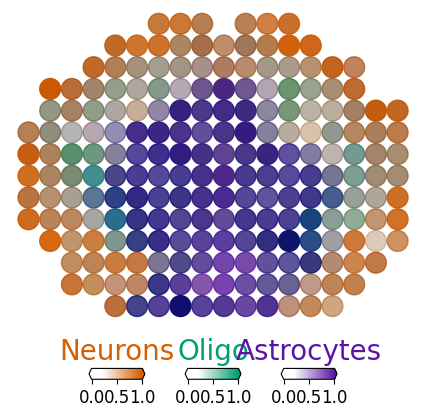

In [23]:
# Visualization of the signature score with cell-type specific markers
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

pids = ["Q9JJV5", "P97441","Q8CC35"]
sp_adata.obs["Neurons"] = np.mean(sp_adata.to_df()[pids],axis=1)

pids = ["P04370", "P60202","P16330","Q60771","Q61885"]
sp_adata.obs["Oligo"] = np.mean(sp_adata.to_df()[pids],axis=1)

pids = ["P28571","P31650", "Q9JM63"]
sp_adata.obs["Astrocytes"] = np.mean(sp_adata.to_df()[pids],axis=1)

sp_adata.obs[["Neurons","Oligo","Astrocytes"]]= scaler.fit_transform(sp_adata.obs[["Neurons","Oligo","Astrocytes"]])

plt_gd = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["Neurons","Oligo","Astrocytes"],color=["Neurons","Oligo","Astrocytes"],
    circle_diameter=15.0,reorder_cmap=[1,3,4],max_color_quantile=1)

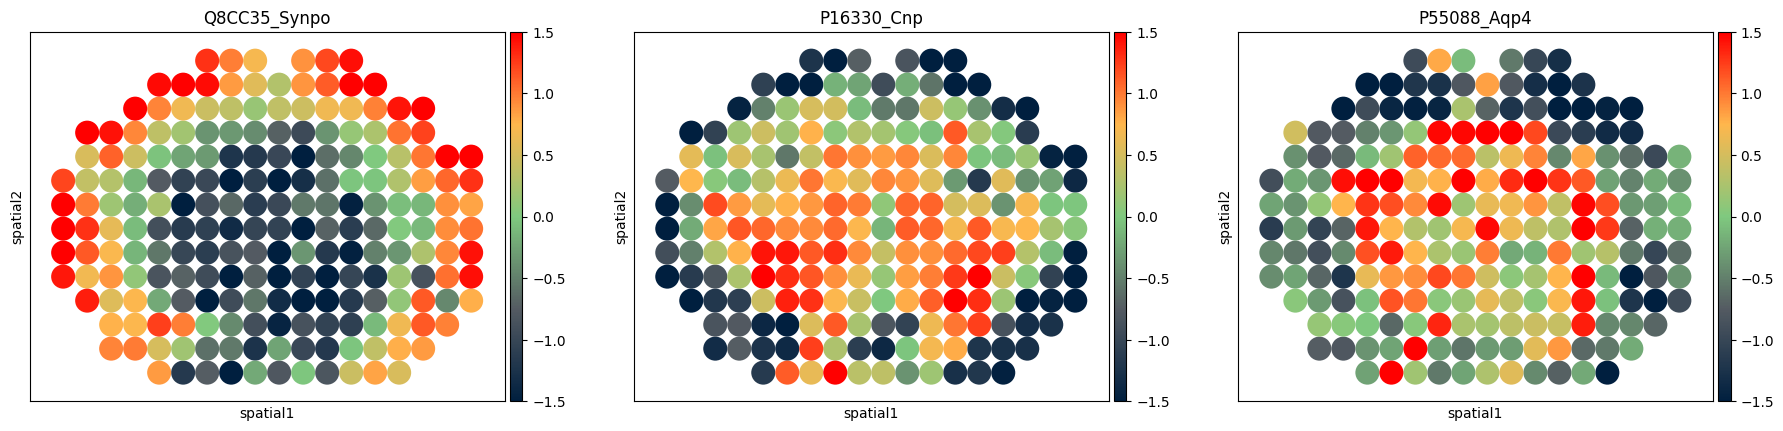

In [17]:
# visualization of known cell-type specific markers from original spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")

colors = ['#001f3f', '#545b62', '#7fc97f', '#ffb74d', 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
pids = ["Q8CC35","P16330","P55088"]
pids_gene = ["Q8CC35_Synpo","P16330_Cnp","P55088_Aqp4"] # ["Neurons","Oligodendrocytes","Astrocytes"]

sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)
sc.pp.scale(sp_adata)

sc.pl.spatial(sp_adata, spot_size=1,color=pids,cmap=my_cmap,vmin=-1.5,vmax=1.5,title=pids_gene)

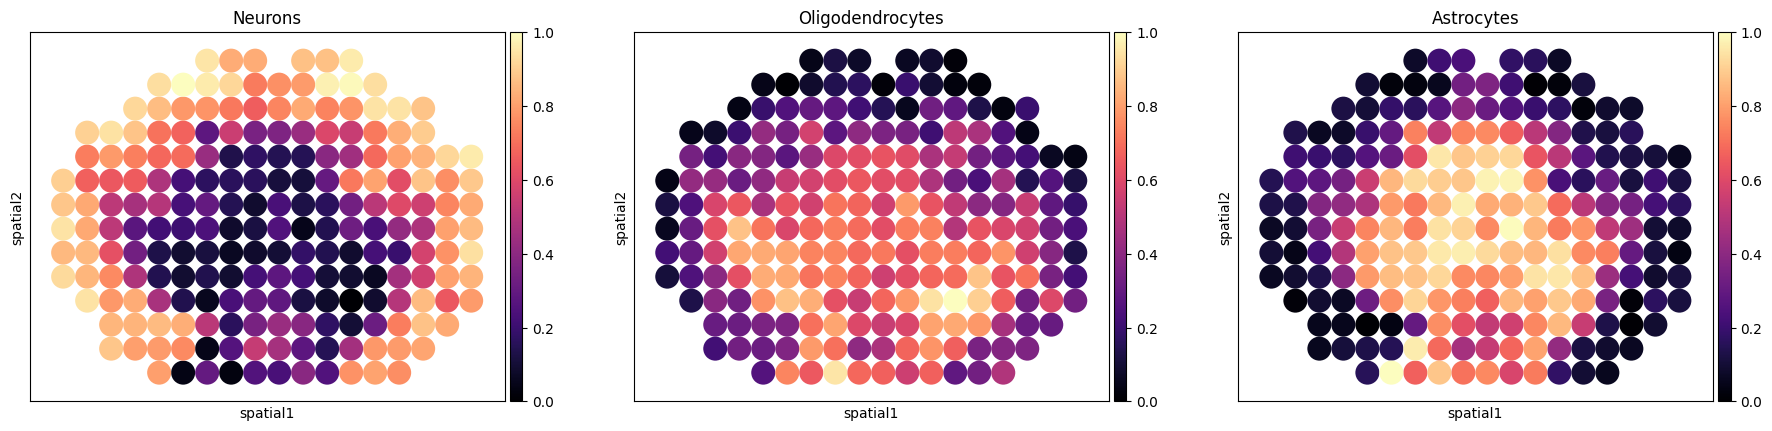

In [16]:
# visualization of corresponding cell types predicted by Spatial_DC
pred_df = pd.read_csv(f"{dataset_dir}/Spatial_DC_pred.csv",index_col=0,sep=",") 
pred_df[pred_df.columns]= scaler.fit_transform(pred_df[pred_df.columns])
ct_order = ["Neurons","Oligodendrocytes","Astrocytes"]

sp_adata.obs = pred_df
sc.pl.spatial(sp_adata, spot_size=1,color=ct_order,cmap="magma")

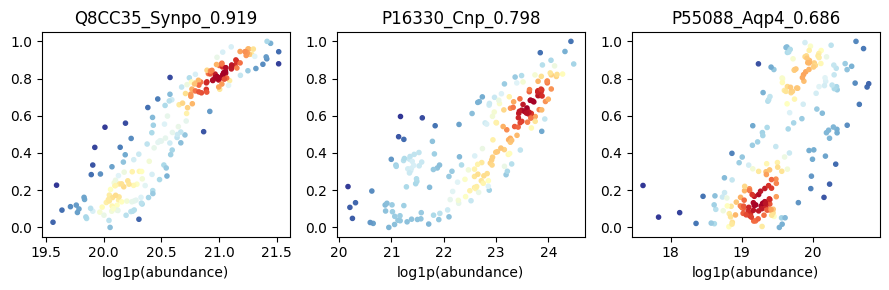

In [19]:
# Dot plot of cell-type composition and cell-type marker proteins
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for j, pid in enumerate(pids):
    
    p = sp_adata.to_df()[pid].values
    g = pred_df[ct_order[j]].values

    temp_pcc = '%.3f' % pearsonr(p,g)[0]
    
    values = np.vstack([g, p])
    kernel = stats.gaussian_kde(values)(values)
    axs[j].scatter(p, g, cmap="RdYlBu_r",c=kernel,marker='.')

    axs[j].set_xlabel("log1p(abundance)")
    axs[j].set_title(f"{pids_gene[j]}_{temp_pcc}")

plt.tight_layout()

# Applications related to predicted cell-type composition

## Benchmarking analysis of predicted cell-type composition

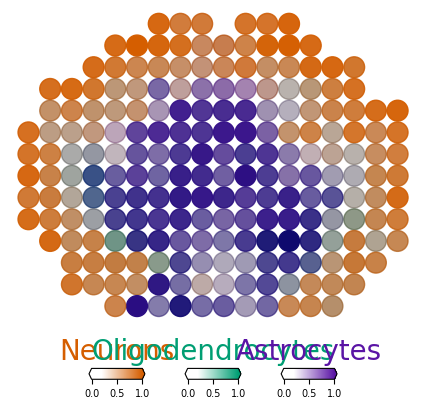

In [46]:
# panel-3 reletive abundance of Ground Truth and Spatial-DC
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

pred_df = pd.read_csv(f"{dataset_dir}/Spatial_DC_pred.csv",index_col=0,sep=",")
ct_order = ["Neurons","Oligodendrocytes","Astrocytes"]

sp_adata.obs[ct_order]= scaler.fit_transform(scaler.fit_transform(pred_df[ct_order]))

plt_pred = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=ct_order,color=ct_order,
    circle_diameter=15.0,reorder_cmap=[1,3,4],max_color_quantile=1,colorbar_tick_size=7)

In [53]:
# Calculate PCC and SPCC metrics
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

pred_df = pd.read_csv(f"{dataset_dir}/Spatial_DC_pred.csv",index_col=0,sep=",")
methods = ["SpatialDC"]

ct_order = ["Neurons","Oligodendrocytes","Astrocytes"]

sp_adata.obs[ct_order]= scaler.fit_transform(pred_df[ct_order])         

results = []

for ct in ct_order:
    if(ct == "Neurons"):
        pids = ["Q9JJV5", "P97441","Q8CC35"]

    elif(ct == "Oligodendrocytes"):
        pids = ["P04370", "P60202","P16330","Q60771","Q61885"]
    elif(ct == "Astrocytes"):
        pids = ["P28571","P31650", "Q9JM63"]
    if(np.sum(sp_adata.obs[ct]) == 0):
        temp_PCC.append(0)
        temp_SPCC.append(0)
        continue
    
    corr_matrix = pd.DataFrame(sp_adata.to_df()[pids]).corrwith(sp_adata.obs[ct])  
    corr_matrix = corr_matrix.dropna()
    
    corr_matrix2 = pd.DataFrame(sp_adata.to_df()[pids]).corrwith(sp_adata.obs[ct],method="spearman")         
    corr_matrix2 = corr_matrix2.dropna()


    results.append({
        'Method': 'Spatial-DC',
        'CellType': ct,
        'PCC_metrics': '%.3f' % np.mean(corr_matrix),
        'SPCC_metrics': '%.3f' % np.mean(corr_matrix2)
    })    
                                
print(pd.DataFrame(results))

       Method          CellType PCC_metrics SPCC_metrics
0  Spatial-DC           Neurons       0.897        0.901
1  Spatial-DC  Oligodendrocytes       0.775        0.798
2  Spatial-DC        Astrocytes       0.864        0.814


# Applications related to reconstructed cell-type proteomic profiles

## Signaling analysis for reconstructed proteomic profiles
Involving NCAM signaling and EPHB signaling

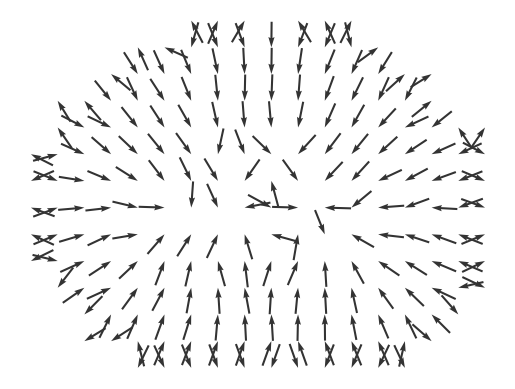

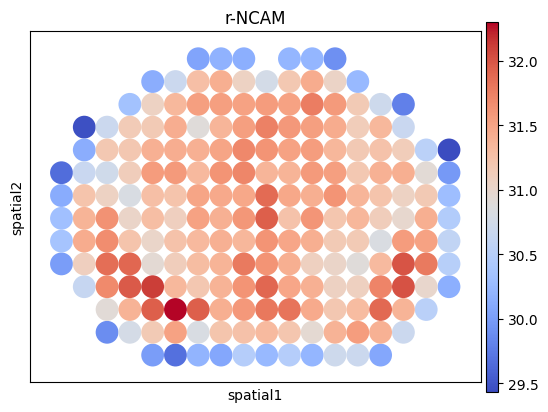

In [65]:
# Communication of Neurons
import commot as ct

scp_adata = sc.read_h5ad(f"{dataset_dir}/Spatial_DC_reconstruct_not_norm.h5ad") # using actual reconstructed data without normalization by predicted cell-type composition

# set zero of cellperc<0
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

sender_cell = "Neurons"
receiver_cell = "Neurons"

keep_ct = scp_adata.obs["celltype"].isin([sender_cell])
target_adata = scp_adata[keep_ct,:].copy()

sc.pp.log1p(target_adata)
sc.pp.filter_genes(target_adata,min_cells=10)

temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])

target_adata.var.index = target_adata.var["gene"]

target_adata.var_names = target_adata.var_names.astype(str)
target_adata.var_names_make_unique()

pathway_name = "NCAM"
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type=None, database='CellChat')
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, target_adata, min_cell_pct=0.05) #40

df_cellchat_filtered = df_cellchat[df_cellchat.iloc[:,2] == pathway_name]
sender_pid = list(set(df_cellchat_filtered.iloc[:,0]))
receiver_pid = list(set(df_cellchat_filtered.iloc[:,1]))

keep_index = target_adata.var["gene"].isin(sender_pid + receiver_pid)
keep_ct = target_adata.obs["celltype"].isin([sender_cell])
target_adata = target_adata[keep_ct,keep_index].copy()

ct.tl.spatial_communication(target_adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='cellchat', pathway_name='NCAM', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='cellchat', pathway_name='NCAM',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=1,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_NCAM_receiver_0.5.pdf",plot_method="cell")

target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])

target_adata.obs[f'r-NCAM'] = target_adata.obsm['commot-cellchat-sum-receiver'][f'r-NCAM']
sc.pl.spatial(target_adata,spot_size=1,color=[f'r-NCAM'],cmap="coolwarm")

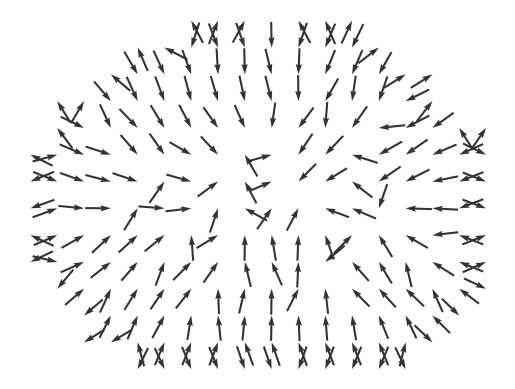

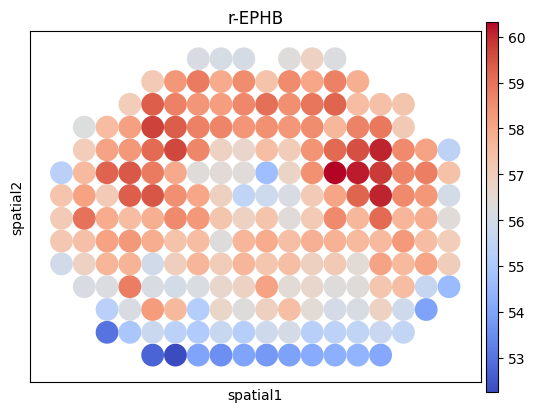

In [66]:
scp_adata = sc.read_h5ad(f"{dataset_dir}/Spatial_DC_reconstruct_not_norm.h5ad") # using actual reconstructed data without normalization by predicted cell-type composition

# set zero of cellperc<0
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

sender_cell = "Astrocytes"
receiver_cell = "Neurons"
pathway_name = "EPHB"

scp_adata.var.index = scp_adata.var["gene"]
scp_adata.var_names = scp_adata.var_names.astype(str)
scp_adata.var_names_make_unique()

df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type=None, database='CellChat')
df_cellchat = ct.pp.filter_lr_database(df_cellchat, scp_adata, min_cell_pct=0.05) #40
df_cellchat_filtered = df_cellchat[df_cellchat.iloc[:,2] == pathway_name]

sender_pid = list(set(df_cellchat_filtered.iloc[:,0]))
receiver_pid = list(set(df_cellchat_filtered.iloc[:,1]))

# for sender
keep_index = scp_adata.var["gene"].isin(sender_pid + receiver_pid)
keep_ct = scp_adata.obs["celltype"].isin([sender_cell])
target_adata = scp_adata[keep_ct,keep_index].copy()

target_adata.var.index = target_adata.var["gene"]
temp_df = target_adata.to_df()

# for receiver
keep_index = scp_adata.var["gene"].isin(receiver_pid)
keep_ct = scp_adata.obs["celltype"].isin([receiver_cell])
temp_df[receiver_pid]  = scp_adata[keep_ct,keep_index].to_df().values #replace

target_adata.X = np.array(temp_df)

# prepare adata
sc.pp.log1p(target_adata)
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])

temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

ct.tl.spatial_communication(target_adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='cellchat', pathway_name=pathway_name, k=5)

ct.pl.plot_cell_communication(target_adata, database_name='cellchat', pathway_name='EPHB',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=1,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_EPHC_receiver_0.5.pdf",plot_method="cell")

target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
target_adata.obs[f'r-{pathway_name}'] = target_adata.obsm['commot-cellchat-sum-receiver'][f'r-{pathway_name}']
sc.pl.spatial(target_adata,spot_size=1,color=[f'r-{pathway_name}'],cmap="coolwarm",save=f"{pathway_name}_strength.pdf")
